### Импорт библиотек

In [351]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, accuracy_score

from sklearn.preprocessing import  OneHotEncoder
import category_encoders as ce
from sklearn.decomposition import PCA

### Загрузка данных

In [352]:
X_test = np.load('data/X_test.npy')
X_train = np.load('data/X_train.npy')
y_train = pd.read_csv('data/y_train.csv')
sub = pd.read_csv('data/sample_submission.csv')
y_train, sub = y_train['Class'], pd.DataFrame(sub['Class'])

print(f'X_train shape:{X_train.shape}, X_test shape:{X_test.shape}, y_train shape:{y_train.shape}, sub shape:{sub.shape}')

X_train shape:(165, 40, 60), X_test shape:(166, 40, 60), y_train shape:(165,), sub shape:(166, 1)


### Работа c данными(EDA)

**Описание данных**

X_train.npy и X_test.npy имеют следующие размерности (наблюдения, датчики, время);

y_train.csv содержит следующие классы:

|Кодировка жеста     |Расшифровка        ||Кодировка жеста     |Расшифровка        |
|--------------------|-------------------|----|--------------------|-------------------|
|"0"| разгиб жеста "grab"|*|"8" | сгиб мизинца|
|"1" | разгиб жеста "ok"|*|"9" | сгиб безымянного пальца|
|"2" | разгиб большого пальца|*|"10" | сгиб среднего пальца|
|"3" | разгиб указательного пальца|*|"11" | сгиб жеста "пистолет"|
|"4" | разгиб жеста "пистолет"|*|"12" | сгиб указательного пальца|
|"5" | разгиб среднего пальца|*|"13" | сгиб большого пальца|
|"6" | разгиб безымянного пальца|*|"14" | сгиб жеста "ok"|
|"7" | разгиб мизинца|*|"15" | сгиб жеста "grab"|

Проверим датасет на пропущенные значения

In [353]:
flag = False
for i in range(X_train.shape[0]):
    for j in range(X_train.shape[1]):
        for k in range(X_train.shape[2]):
            if X_train[i][j][k] is np.nan:
                flag = True
print(f'Есть пропущенные значения? - {flag}')

Есть пропущенные значения? - False


Создадим два словаря жестов, чтобы в будущем проще было ориентироваться.

Первый словарь соотносит код жеста с описанием его выполнения.

Второй разделяет и записывает индекс наблюдения в каждый класс жеста.

In [354]:
# словарь перевода жестов с численного типа к строчному
sign_dict = {0:'разгиб жеста "grab"',1:'разгиб жеста "ok"',2:'разгиб большого пальца',3:'разгиб указательного пальца',
             4:'разгиб жеста "пистолет"',5:'разгиб среднего пальца',6:'разгиб безымянного пальца',
             7:'разгиб мизинца',8:'сгиб мизинца',9:'сгиб безымянного пальца',10:'сгиб среднего пальца',
             11:'сгиб жеста "пистолет"',12:'сгиб указательного пальца',13:'сгиб большого пальца',
             14:'сгиб жеста "ok"',15:'сгиб жеста "grab"'}

# создадим словарь жестов с номерами наблюдений в нашем датасете
dict_ind = {}

for i in range(y_train.shape[0]):
    dict_ind.setdefault(y_train.loc[i], []).append(i)

Для анализа данных создадим несколько функций

In [355]:
def show_sign_partly(sign: int, n_sensor: int) -> tuple[object, str]:
    """выводит линейный график всех наблюдений данного жеста и датчика и
        возращает краткую информацию о конкретном датчике в конкретном жесте

    Args:
        sign (int): номер жеста
        n_sensor (int): номер датчика

    Returns:
        tuple[object, str]: линейный график всех наблюдений данного жеста и датчика, и
                        краткую информацию о конкретном датчике в конкретном жесте
    """
    examples = dict_ind[sign] 
    
    fig = plt.figure(figsize=(16, 6))
    min_list, max_list = [], []
    for ex in examples:
        min_list.append(X_train[ex][n_sensor - 1].min())
        max_list.append(X_train[ex][n_sensor - 1].max())
        
        line = sns.lineplot(x=list(range(60)), y=X_train[ex][n_sensor - 1], color='Green')
        line.set_title(f'Жест: {sign_dict[sign]}. Датчик №{n_sensor}')
    
    plt.xlim(0, 60)
    plt.ylim(0, 4096)   
    min_line = sns.lineplot(x=list(range(60)), y= [min(min_list)]* 60, label='min', color='black', ls='--')
    max_line = sns.lineplot(x=list(range(60)), y= [max(max_list)]* 60, label='max', color='red', ls='--')
    print(f'MIN: {min(min_list)} MAX: {max(max_list)} DIFF: {max(max_list) - min(min_list)}')
    
   
def show_sign_full(sign: int, value='all') -> object :
    """функция выводит линейный график всех сенсоров конкретного жеста

    Args:
        sign (int): номер жеста
        value (str, optional): сколько примеров жеста нужно вывести. Defaults to 'all'.

    Returns:
        object: линейный график
    """
    examples = dict_ind[sign] if value =='all' else np.random.choice(dict_ind[sign], value)
    if value == 'all':
        for ex in examples:
            fig = plt.figure(figsize=(10, 6))
            for i in range(40):
                line = sns.lineplot(x=list(range(60)), y=X_train[ex][i])
                line.set_title(f'Жест: {sign_dict[sign]}')
    
    else:
        for ex in examples:
            fig = plt.figure(figsize=(10, 6))
            for i in range(40):
                line = sns.lineplot(x=list(range(60)), y=X_train[ex][i])
                line.set_title(f'Жест: {sign_dict[sign]}')


def comprasion_sign(s_1: int, s_2: int) -> object:
    """функция позволяет сравниваить линейные графики сенсоров разных жестов

    Args:
        s_1 (int):первый жест для сравнения
        s_2 (int): второй жест для сравнения

    Returns:
        object: два линейных графика
    """
    s_1_ex = int(np.random.choice(dict_ind[s_1], 1))
    s_2_ex = int(np.random.choice(dict_ind[s_1], 1))

    
    fig, axes = plt.subplots(1, 2, figsize=(25, 6))
    for i in range(40):
        sign_1 = sns.lineplot(x=list(range(60)),y=X_train[s_1_ex][i], ax=axes[0])
        sign_1.set_title(f'Жест: {sign_dict[s_1]}', fontsize=15)
    for i in range(40):
        sign_2 = sns.lineplot(x=list(range(60)),y=X_train[s_2_ex][i], ax=axes[1])
        sign_2.set_title(f'Жест: {sign_dict[s_2]}', fontsize=15)
        
    plt.tight_layout()
    
def show_hist_kde(value: int, sensor: int) -> object:
    """функция показывает распределение показаний на конкретном наблюдении

    Args:
        value (int): начальный номер наблюдения 
        sensor (int): номер датчика

    Returns:
        object: возращает гистограмму с kde линией пяти наблюдений начиная с заданного value
    """
    sample = pd.DataFrame(X_train[value: value + 5, sensor,:]).T
        
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    for i in range(5):
        hist = sns.histplot(data=sample, x=i, kde=True, ax=axes[i], bins=10)
        hist.set_xlabel(f'Наблюдение №{value + i} Датчик №{sensor}')
    fig.tight_layout()

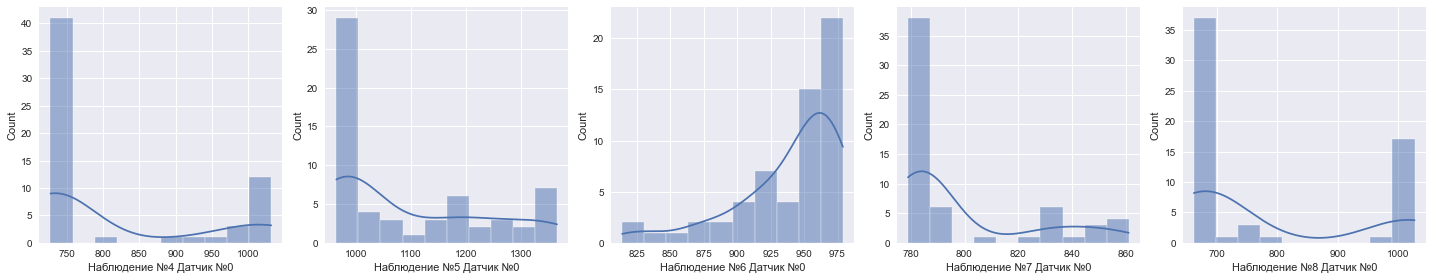

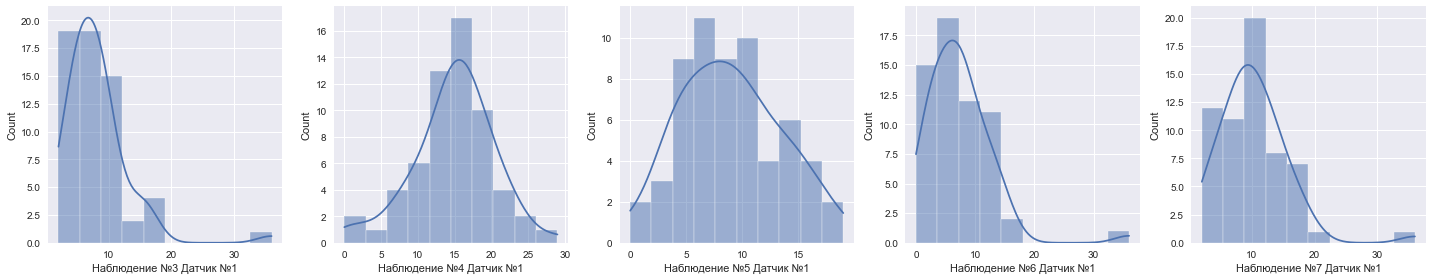

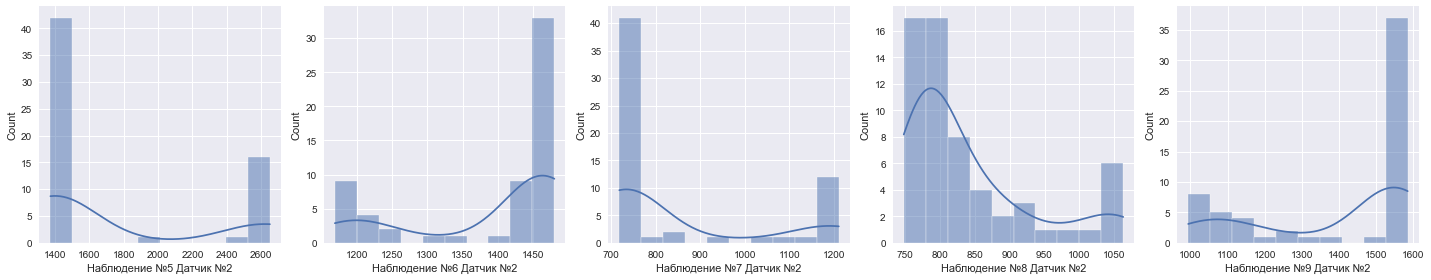

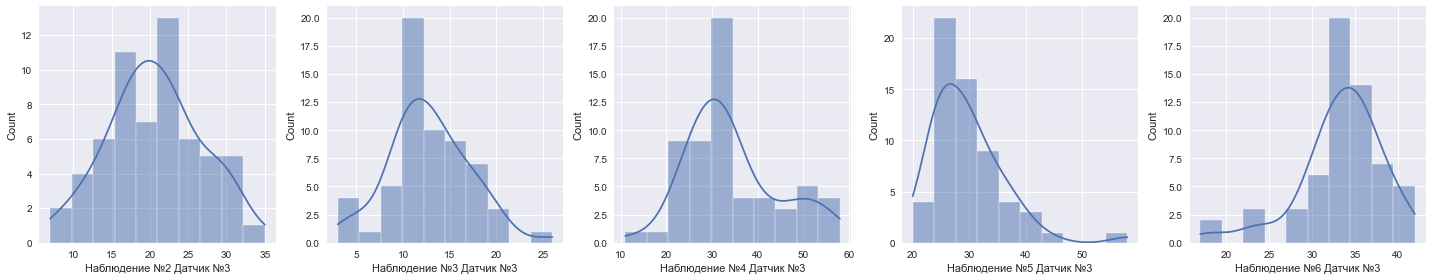

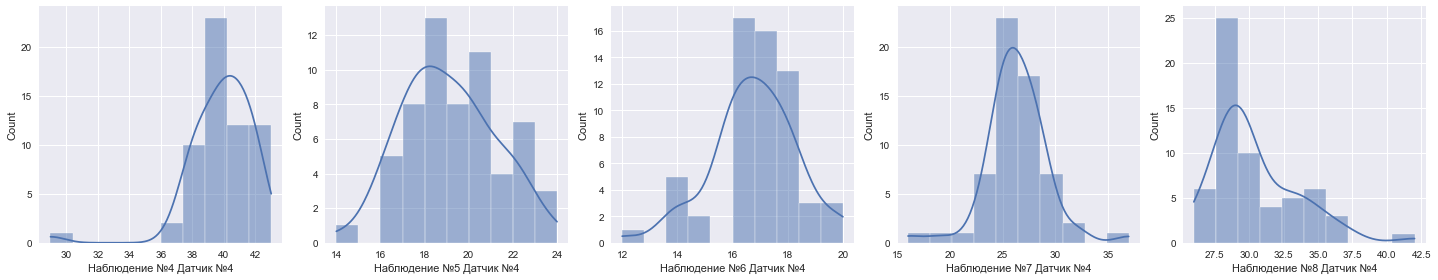

In [356]:
# Посмтрим на 5 разных датчиков в 5 наблюдений 
for i in range(5):
    show_hist_kde(np.random.randint(0, 10), i)

На гистограммах имеются:

1. Нормальное распределение показаний, что говорит о том что датчик не отработал и имеются шумы.

2. Распределение с 2 вершинами, что говорит о четком сигнале при срабатывании

3. Встречаются не четкие распределения, которые вызваны дрейфом датчиков.

Взглянем на два противоположных жеста

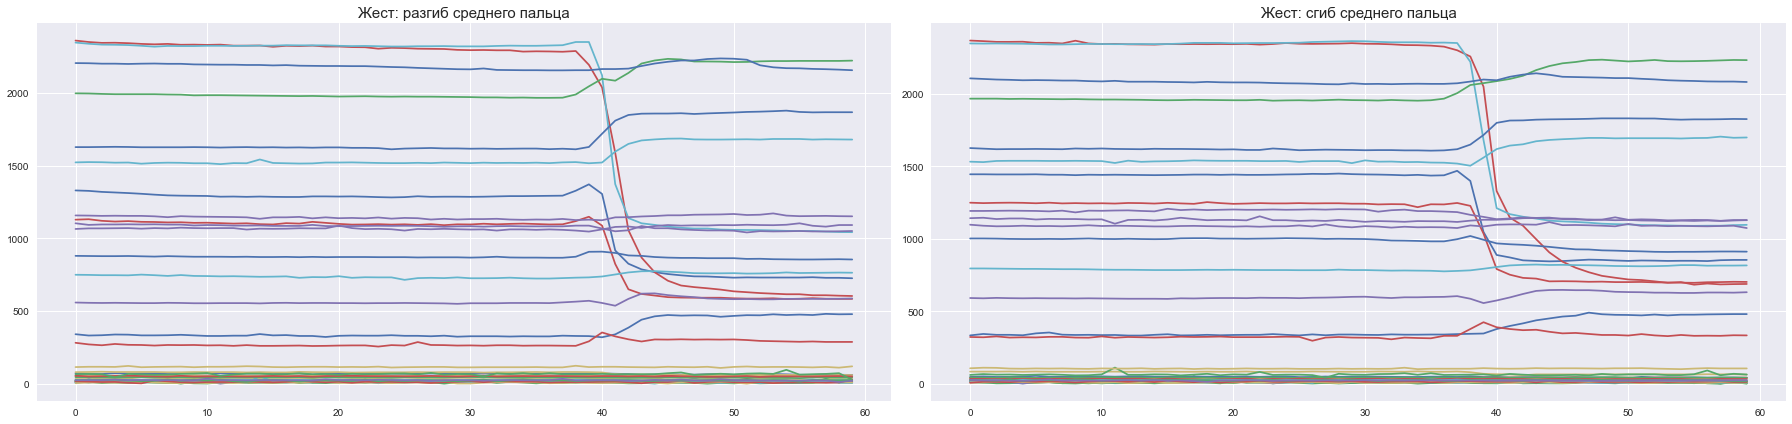

In [357]:
comprasion_sign(5, 10)

Видно противоположное направление и разная амлитуда у некоторых датчиков. Они скорее всего и будут являются ключевыми в предсказании жеста. Для этого мы поделим на классы динамику волн

Как видно на рисунках ниже, масштаб амплитуды датчиков очень большой. Поэтому,чтобы закодировать динамику сенсора, нам нужно точно подобрать герцовку направления движения волны.

MIN: 725.0 MAX: 1925.0 DIFF: 1200.0


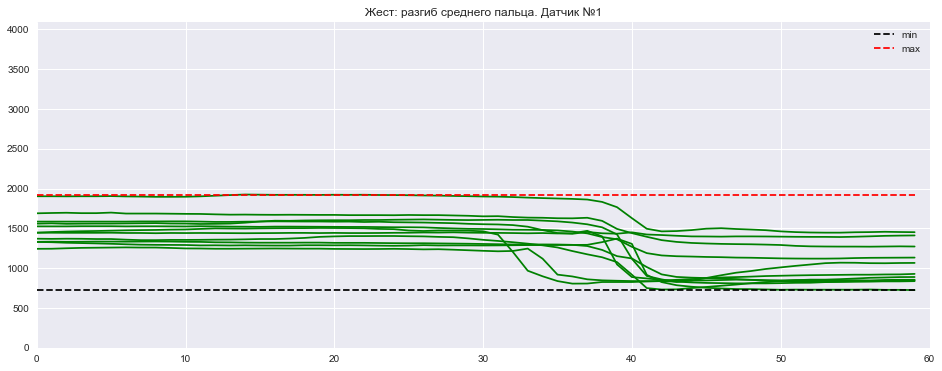

In [358]:
show_sign_partly(5, 1)

MIN: 687.0 MAX: 2703.0 DIFF: 2016.0


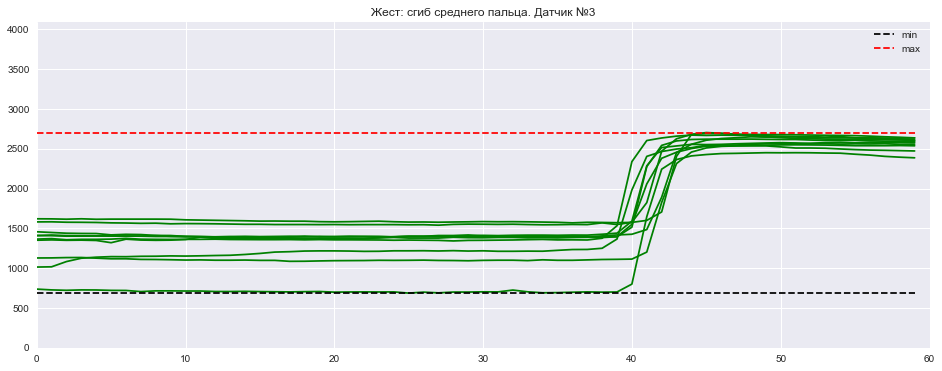

In [359]:
show_sign_partly(10, 3)

MIN: 910.0 MAX: 1832.0 DIFF: 922.0


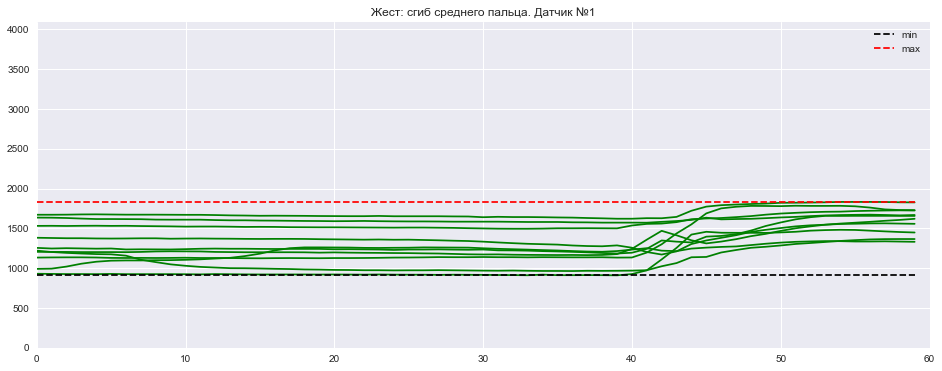

In [360]:
show_sign_partly(10, 1)

Судя по графикам выше, вся динамика волны происходит после 30 еденицы времени. Поэтому смело можем обрезать датасет с 30-ого значения

Также можно посмотреть на корреляцию значений, например 45-ого наблюдения

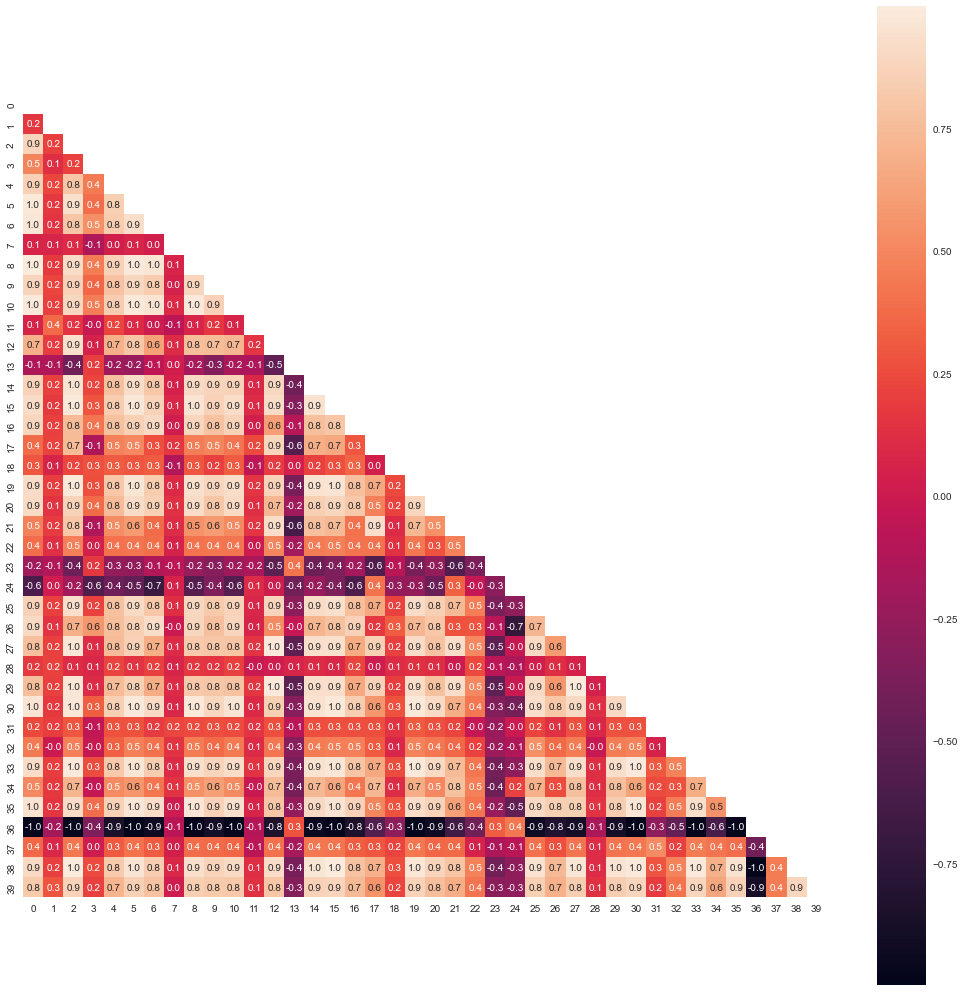

In [361]:
corr = np.corrcoef(X_train[54], rowvar=True)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(18, 18))
    ax = sns.heatmap(corr, mask=mask, annot=True, fmt='.1f', square=True)

Видна большая корреляция между датчиками, что логично. Деление на классы динамики волн поможет нам ее снизить.

In [362]:
X_test = np.load('data/X_test.npy')
X_train = np.load('data/X_train.npy')

### Регуляризация данных

Создадим регулятор повышения/понижения границ определения динамики волны

In [363]:
def reg(step_inc=0, step_dec=0, noise=0) -> object:
    """Регулятор повышения/понижения границ определения динамики волны

    Args:
        step_inc (int, optional): регулеровка повышения волны. Defaults to 0.
        step_dec (int, optional): регулеровка понижения волны. Defaults to 0.
        noise (int, optional): регулеровка уровня шума. Defaults to 0.

    Returns:
        object: DataFrame основанный на нашей регулизации определения динамики волны
    """
    df = pd.DataFrame(data = np.nan, index = [x for x in range(X_train.shape[0])],
                 columns = ['sensor_'+ str(y + 1) for y in range(X_train.shape[1])], dtype = object)
    for i in range(len(X_train)):
        for j in range(len(X_train[i])):
            arr = (X_train[i][j])
            if (arr[0]-arr[-1]) < -350 + step_inc:
                df.iloc[i][j] = "pow+"
            elif (arr[0]-arr[-1]) > 350 + step_dec:
                df.iloc[i][j] = "pow-"
            elif abs(arr[0]-arr[-1]) < 150 + noise:
                df.iloc[i][j] = "noise"
            else:
                df.iloc[i][j] = "dr"
    
    return df

Создадим быструю проверку наших значений на логистической регресии

In [364]:
def test(data: pd.DataFrame, return_report=False) -> str:
    """функция возращает метрику accuracy основанной на нашем датасете(созданным регулятором),
    построенной на базовой логистической модели

    Args:
        data (pd.DataFrame): _description_
        return_report (bool, optional): _description_. Defaults to False.

    Returns:
        str: метрику accuracy
    """
    df_std = OneHotEncoder(sparse = False).fit_transform(data.values)
    
    X_train, X_test, Y_train_, Y_test_ = train_test_split(df_std, y_train, shuffle=True, test_size=0.3, random_state=40)

    model = LogisticRegression(max_iter=1000, random_state=40)

    model.fit(X_train, Y_train_)
    y_predict = model.predict(X_test)
    score = accuracy_score(y_predict, Y_test_)
    scores = classification_report(y_predict, Y_test_, zero_division=1)
    if return_report:
        print(scores)
    else:
        return score

Создадим 20 шагов регулировки для опреления повышения/понижения волны и определения шума. Также построим модели на данных значениях

In [365]:
accuracy_list = []
step_inc_list = np.linspace(-300, 300, 20)
step_dec_list = np.linspace(-300, 300, 20)
noise_list = np.linspace(-100, 100, 20)

for i in range(20):
    df = reg(step_inc= step_inc_list[i], step_dec=step_dec_list[i], noise=noise_list[i])
    accuracy_list.append(test(df))

Построим график для определения лучших значений для модели

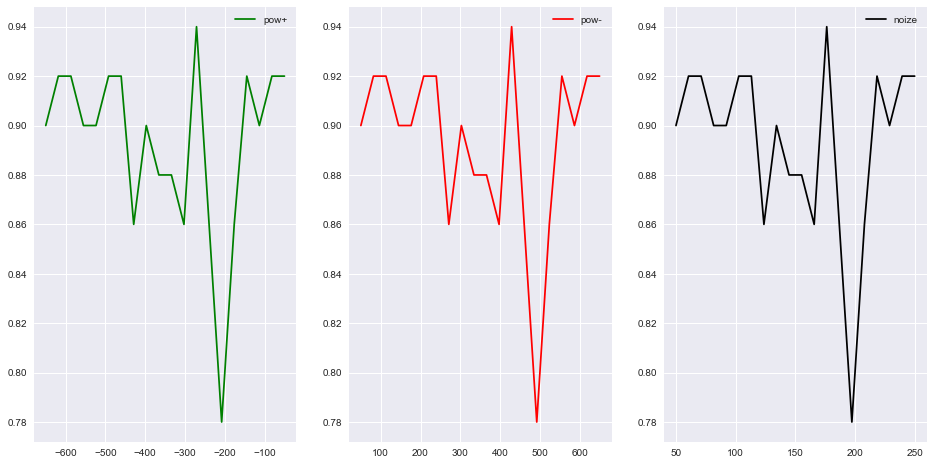

In [366]:
fig, axes = plt.subplots(1, 3, figsize=(16, 8))

sns.lineplot(x=[i - 350 for i in step_inc_list], y=accuracy_list, ax=axes[0], color='green', label='pow+')
sns.lineplot(x=[i + 350 for i in step_dec_list], y=accuracy_list, ax=axes[1], color='red', label='pow-')
sns.lineplot(x=[i + 150 for i in noise_list], y=accuracy_list, ax=axes[2], color='black', label='noize');

Видно что диаграммы прохожи. Поэтому придется регулировать каждый уровень по отдельности

In [367]:
accuracy_list_up, accuracy_list_down, accuracy_list_n = [], [], []

step_inc_list = np.linspace(-500, 500, 20)
step_dec_list = np.linspace(-500, 500, 20)
noise_list = np.linspace(0, 200, 20)

In [368]:
for i in range(20):
    df = reg(step_inc= step_inc_list[i])
    accuracy_list_up.append(test(df))

for i in range(20):
    df = reg(step_dec=step_dec_list[i])
    accuracy_list_down.append(test(df))

for i in range(20):
    df = reg(noise=noise_list[i])
    accuracy_list_n.append(test(df))

Выведем наши результаты

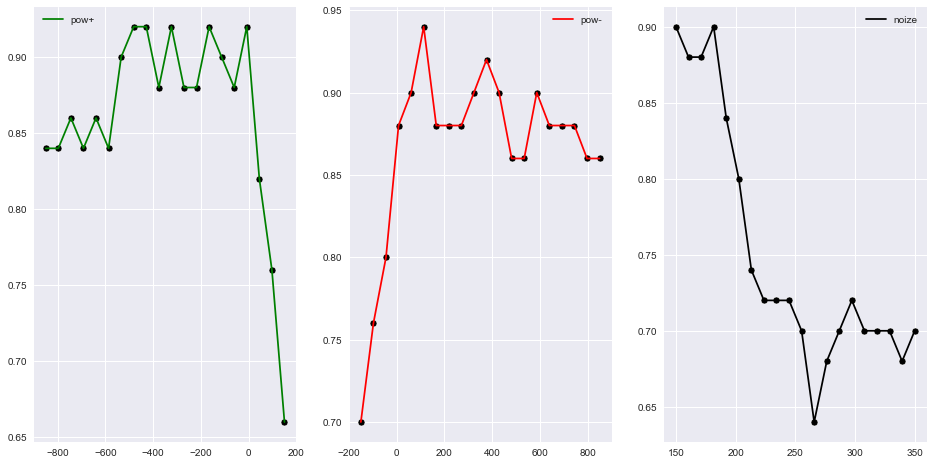

In [369]:
fig, axes = plt.subplots(1, 3, figsize=(16, 8))

sns.lineplot(x=[-350 + i for i in step_inc_list], y=accuracy_list_up, ax=axes[0], color='green', label='pow+')
sns.scatterplot(x=[-350 + i for i in step_inc_list], y=accuracy_list_up, ax=axes[0], color='black')

sns.lineplot(x=[350 + i for i in step_dec_list], y=accuracy_list_down, ax=axes[1], color='red', label='pow-')
sns.scatterplot(x=[350 + i for i in step_dec_list], y=accuracy_list_down, ax=axes[1], color='black')

sns.lineplot(x=[i + 150 for i in noise_list], y=accuracy_list_n, ax=axes[2], color='black', label='noize')
sns.scatterplot(x=[i + 150 for i in noise_list], y=accuracy_list_n, ax=axes[2], color='black');

Видно, что при изменения уровня определения шума, модель показывает результаты ниже ожидаемого.

Нойз можно оставить на прежнем уровне

In [370]:
pow_plus = np.array([step_inc_list[7],step_inc_list[8],step_inc_list[10],step_inc_list[13],step_inc_list[16]]).round()
print(f'Лучшие значеня при повышении уровня: {pow_plus}')

Лучшие значеня при повышении уровня: [-132.  -79.   26.  184.  342.]


In [371]:
print(f'Лучшее значение при понижении уровня: {round(350 + step_dec_list[5])}')

Лучшее значение при понижении уровня: 113


Также для обозначения понижения волны мы оставим порог в 113hz. И выясним какое значения наилучшее для определения повышения волны

In [372]:
final_acc_list = []
for elem in range(len(pow_plus)):
    df = reg(step_inc=step_dec_list[elem], step_dec=step_dec_list[5])
    final_acc_list.append(test(df))

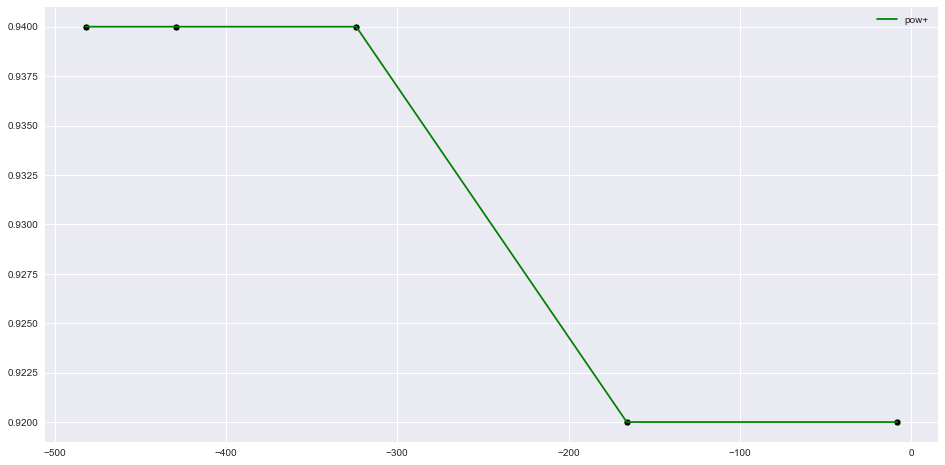

In [373]:
fig= plt.figure(figsize=(16, 8))

sns.lineplot(x=[-350 + i for i in pow_plus], y=final_acc_list, color='green', label='pow+')
sns.scatterplot(x=[-350 + i for i in pow_plus], y=final_acc_list, color='black');

Как видно наша модель показывает лучшее значение при числах меньше нуля

In [374]:
print(f'Лучшее значение при понижении уровня: {round(-350 + pow_plus[0])}')

Лучшее значение при понижении уровня: -482


Построим модель на наших лучших значениях

In [375]:
step_inc=-132
step_dec=-237

При использовании лучших значений на тестовых данных результат оказался низкий

Для устранения шума и разницы в частотах перейдем к отношению "(Начало - Конец) / Начало", что нам даст процентное отклонение конечного значения от начального значения, поможет избавиться от влияния разницы частот на результат и отсеять шум в районе 10%


### Преобразование новых данных

Загрузим данные заново

In [391]:
X_test = np.load('data/X_test.npy')
X_train = np.load('data/X_train.npy')

Преобразуем два датасета(X_train, X_test)

In [392]:
df = (X_train[:, :, 0] - X_train[:, :, -1] + 1) / (X_train[:, :, 0] + 1)
df_test = (X_test[:, :, 0] - X_test[:, :, -1] + 1) / (X_test[:, :, 0] + 1)

In [393]:
for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        if df[i, j] < -0.1:
            df[i, j] = -1
        elif df[i, j] > 0.1:
            df[i, j] = +1
        else:
            df[i, j] = 0

for i in range(df_test.shape[0]):
    for j in range(df_test.shape[1]):
        if df_test[i, j] < -0.1:
            df_test[i, j] = -1
        elif df_test[i, j] > 0.1:
            df_test[i, j] = +1
        else:
            df_test[i, j] = 0

### Построение модели

Сначала посмотрим как модель обучилась на тренировочной выборке 

In [394]:
X_train_, X_test_, Y_train_, Y_test_ = train_test_split(df, y_train, shuffle=True, test_size=0.3, random_state=40)

model = LogisticRegression(max_iter=1000, random_state=40)

model.fit(X_train_, Y_train_)
y_predict = model.predict(X_test_)

score = accuracy_score(y_predict, Y_test_)
scores = classification_report(y_predict, Y_test_, zero_division=1)
print(f'Accuracy score is {score}')

Accuracy score is 0.88


In [395]:
print(scores)

              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       1.00      0.75      0.86         4
           2       1.00      0.75      0.86         4
           3       0.80      1.00      0.89         4
           4       0.00      0.00      0.00         1
           5       0.80      1.00      0.89         4
           6       1.00      0.50      0.67         2
           7       0.50      1.00      0.67         1
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         3
          12       0.75      1.00      0.86         3
          13       1.00      1.00      1.00         4
          14       1.00      0.50      0.67         2
          15       1.00      1.00      1.00         3

    accuracy                           0.88        50
   macro avg       0.85   

Модель справилась отлично. Теперь можно предсказать и для тренировочной выборки

In [396]:
model = LogisticRegression(max_iter=1000, random_state=40)

model.fit(df, y_train)
y_predict_test = model.predict(df_test)

sub = pd.read_csv('data/sample_submission.csv')
sub['Class'] = y_predict_test

with open(f"data/data.csv", "w") as file:
    sub.to_csv(file, index=False)
